# Variational Autoencoder

First generative network that we are going to see. 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load MNIST dataset
# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('../data', train=True, download=True, 
                # transforms that we want to apply when iterating the dataset
                   transform=transforms.ToTensor())

# The datasoar will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.ToTensor()),
                    batch_size=1000, shuffle=True)

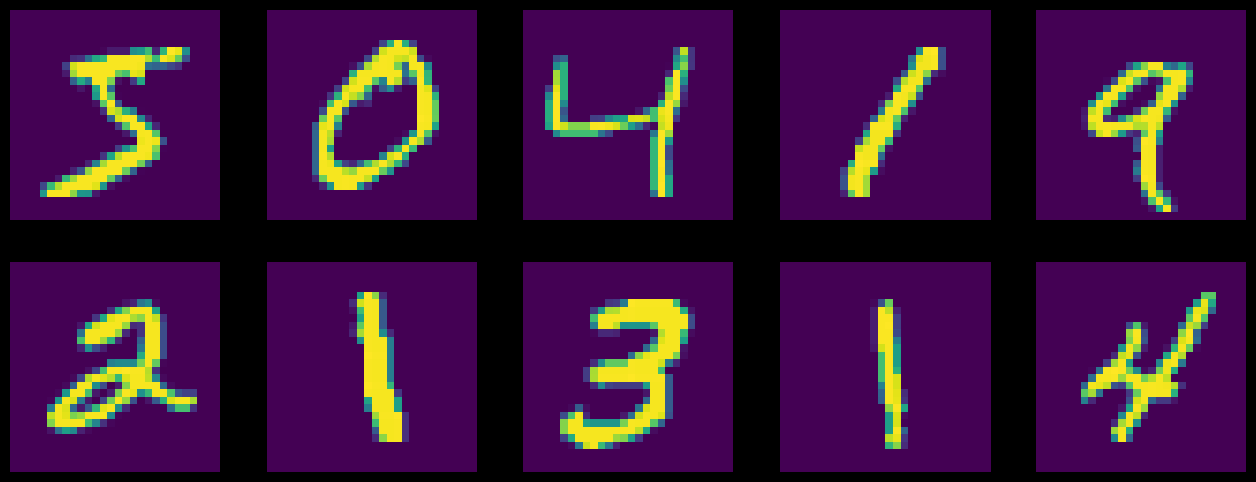

In [3]:
# show some images
to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(image))
    plt.axis('off')

In [4]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Let's define our VAE

class VAE(nn.Module):
    def __init__(
        self,
        image_channels=1,
        hidden_size=64,
        latent_size=2
    ):
        super(VAE, self).__init__()
        
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        
        ## encoder ##
        self.Encoder = nn.Sequential(nn.Conv2d(1, 16, 4, stride = 2, padding=1), #16x14x14   [(W−K+2P)/S]+1
                                        nn.ReLU(),
                                        nn.Conv2d(16, 32, 4, stride = 2, padding=1), #32x7x7
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, stride = 2, padding=1), #64x4x4
                                        nn.ReLU(),
                                        nn.Conv2d(64, self.hidden_size, 4, stride = 1, padding=0), #64x1x1
                                        nn.ReLU(), 
                                        nn.Flatten())  #hidden_size
        

        # define mean
        self.encoder_mean = nn.Linear(self.hidden_size, self.latent_size)
        #define logvar
        self.encoder_logvar = nn.Linear(self.hidden_size, self.latent_size)
        
        self.resize_fc = nn.Linear(self.latent_size, self.hidden_size)
        
        ## decoder ##
        self.Decoder = nn.Sequential(nn.ConvTranspose2d( self.hidden_size, 64, 4, 1, 0), #4x4  (W - 1)S -2P + (K - 1) + 1
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 64, 32, 3, 2, 1), #7x7
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 32, 16, 4, 2, 1), #14x14
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 16, 1, 4, 2, 1), #28x28
                                    nn.Sigmoid())

    def sample(self, log_var, mean):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    
    def KL_loss(self, log_var, mean):
        return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    def forward(self, x):
        x = self.Encoder(x).view(x.size(0),-1)
        log_var = self.encoder_logvar(x)
        mean = self.encoder_mean(x)
        z = self.sample(log_var, mean)
        
        x = self.resize_fc(z).view(z.size(0),self.hidden_size,1,1)
        
        x = self.Decoder(x)

        return x, log_var, mean
    
    def generate_img(self, z):
        x = self.resize_fc(z).view(z.size(0),64,1,1)    
        return self.Decoder(x)


vae = VAE().to(device)
print(vae)    

VAE(
  (Encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder_mean): Linear(in_features=64, out_features=2, bias=True)
  (encoder_logvar): Linear(in_features=64, out_features=2, bias=True)
  (resize_fc): Linear(in_features=2, out_features=64, bias=True)
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2)

In [6]:
# define Optimizer and Loss
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# as loss lets use BCE (Binary Cross Entropy)
bce_loss = nn.BCELoss(reduction="sum")

In [7]:
# TRAIN!!!

PATH = "./res/vae.pth"

vae.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data = data.to(device)
        
        optimizer.zero_grad()
        output, log_var, mean = vae(data)
        # loss between the output of AE and original data withoud noise
        bce = bce_loss(output, data)
        kl = vae.KL_loss(log_var, mean)
        loss = bce + kl
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE: {:.6f} KL: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), bce.item(), kl.item()))
    
    # save model every epoch
    torch.save(vae.state_dict(), PATH)

Train Epoch: 0 [0/60000 (0%)]	BCE: 33868.109375 KL: 0.506515
Train Epoch: 0 [12800/60000 (21%)]	BCE: 12638.878906 KL: 155.668472
Train Epoch: 0 [25600/60000 (43%)]	BCE: 11238.039062 KL: 272.937653
Train Epoch: 0 [38400/60000 (64%)]	BCE: 10818.864258 KL: 302.575470
Train Epoch: 0 [51200/60000 (85%)]	BCE: 9565.041016 KL: 329.790588
Train Epoch: 1 [0/60000 (0%)]	BCE: 10817.764648 KL: 325.146545
Train Epoch: 1 [12800/60000 (21%)]	BCE: 10082.335938 KL: 313.662903
Train Epoch: 1 [25600/60000 (43%)]	BCE: 10817.450195 KL: 306.292877
Train Epoch: 1 [38400/60000 (64%)]	BCE: 9895.832031 KL: 322.379486
Train Epoch: 1 [51200/60000 (85%)]	BCE: 10127.272461 KL: 330.681213
Train Epoch: 2 [0/60000 (0%)]	BCE: 10414.375977 KL: 339.338257
Train Epoch: 2 [12800/60000 (21%)]	BCE: 9668.495117 KL: 327.731720
Train Epoch: 2 [25600/60000 (43%)]	BCE: 8774.201172 KL: 356.498535
Train Epoch: 2 [38400/60000 (64%)]	BCE: 9805.851562 KL: 341.634705
Train Epoch: 2 [51200/60000 (85%)]	BCE: 9165.803711 KL: 349.083862
Tra

In [8]:
#Load a set of weights
vae.load_state_dict(torch.load(PATH))

<All keys matched successfully>

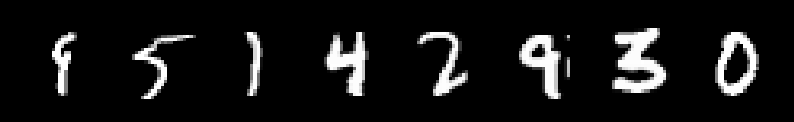

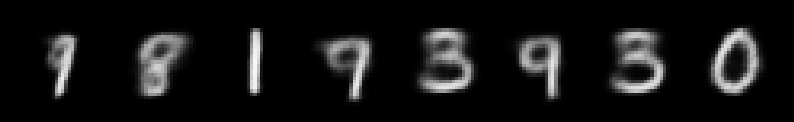

In [9]:
# TEST
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)

vae.eval()

out, _, _ = vae(image)

# input
plt.figure()
image_grid = torchvision.utils.make_grid(image[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")
plt.show()

# output
plt.figure()
out_grid = torchvision.utils.make_grid(out[:8])
plt.imshow(to_pil(out_grid))
plt.axis("off")
plt.show()

torch.Size([8, 2])


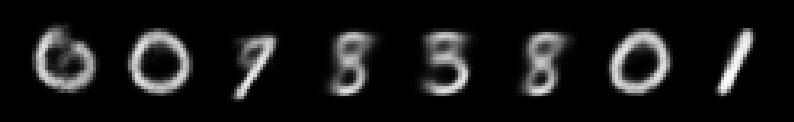

In [11]:
# GENERATE!!!!
z = torch.randn(8,2).to(device)
print(z.size())

generated_samples = vae.generate_img(z)

plt.figure()
gen_grid = torchvision.utils.make_grid(generated_samples)
plt.imshow(to_pil(gen_grid))
plt.axis("off")
plt.show()


In [12]:
# Let's visualize latent space
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)

_, log_var, mean = vae(image)

# sample noise in the latent space
z = vae.sample(log_var, mean)

z = z.cpu().detach().numpy()

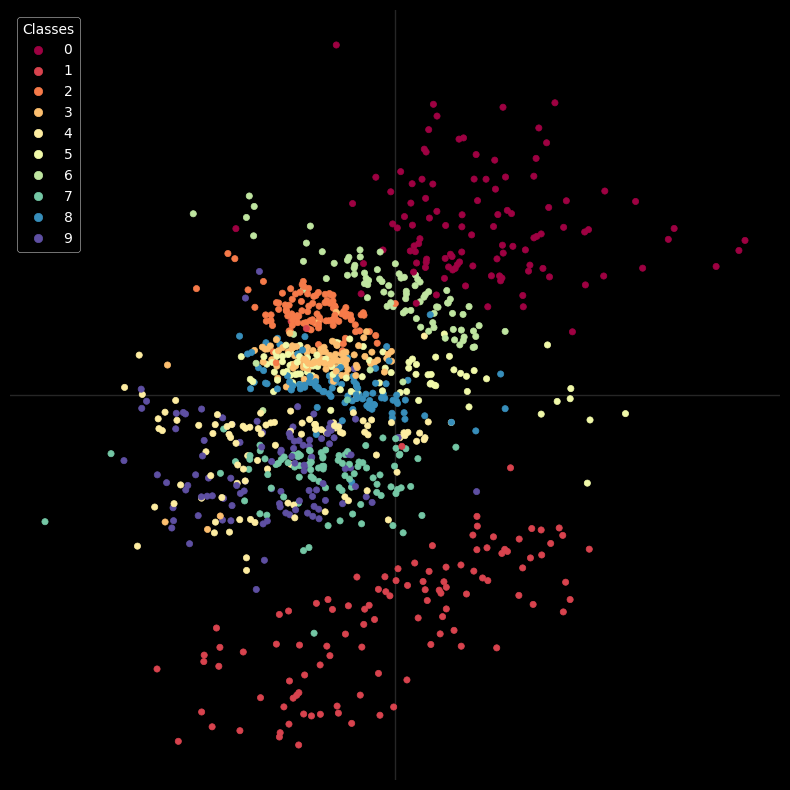

In [13]:
# plot
# scale and move the coordinates so they fit [-1; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [-1; 1] by dividing by its range
    return 2*(starts_from_zero / value_range) - 1

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = z[:, 0]
ty = z[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

z[:, 0] = tx
z[:, 1] = ty

plot_data_np(z, target.numpy(), legend = True)

In [16]:
# function to plot interpolation of generated sample
def plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = vae.generate_img(z)
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat.cpu().detach().numpy()
    plt.imshow(img, extent=[*r0, *r1])
    plt.axis('off')

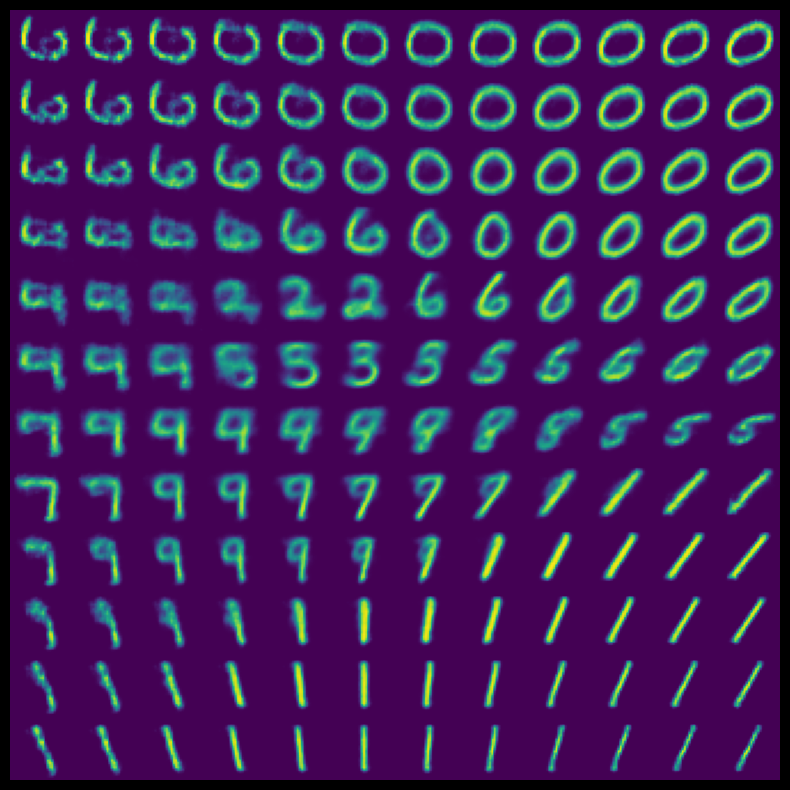

In [17]:
plot_reconstructed(vae)